In [26]:
import pandas as pd
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [27]:
# import cleaned Dataframes from Data preparation
df_cleaned = pd.read_pickle(os.path.join('Data', 'charging_data.pkl'))

# Calculat the session duration in minutes, storing it in a new column `session_duration` in the DataFrame.
df_cleaned['session_duration'] = (
    pd.to_datetime(df_cleaned['disconnectTime']) - pd.to_datetime(df_cleaned['connectionTime'])
).dt.total_seconds() / 60

In [ ]:
#@todo centre
# Keine optimale Anpassung: Manuell festgelegte Zentren können weniger gut zu den Daten passen als automatisch optimierte Zentren.
# Iterative Verbesserung entfällt: K-Means passt die Zentren normalerweise iterativ an. Bei festen Zentren entfällt dieser Vorteil.
# Abhängigkeit von den Daten: Wenn die Daten stark variieren, kann es schwierig sein, sinnvolle Zentren vorab zu definieren.

#@todo viele kleine oder lange dauern
#@todo nach den Stationen unterscheiden
#Nutzerverahlten Clustern (morgens anschließen und nachmtitags weg gehen). oder nur kurz aufladen wollen
#Mehr als zwei User gruppen finde
#was für unterschiedliche cahrging sessions
#Muss auch nicht auf die sides sondern auf user gruppen zu clustern

#Validierung die sides dagegen halten => Hier sind die Cluster und teilen sich auf die sides auf (bei den Extremwerten immer deutlich) ==> 4 Clsuter?


In [ ]:
# Select relevant columns
features = df_cleaned[['charging_duration', 'session_duration']]

# Scaling the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(features)

# Elbow method for determining the optimum number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Plot of the Elbow method
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Anzahl Cluster')
plt.ylabel('Inertia')
plt.title('Elbow-Methode')
plt.show()

         charging_duration  connection_duration
Cluster                                        
0               192.432707           526.792517
1               119.755093           161.280480
2               480.749938           582.254045


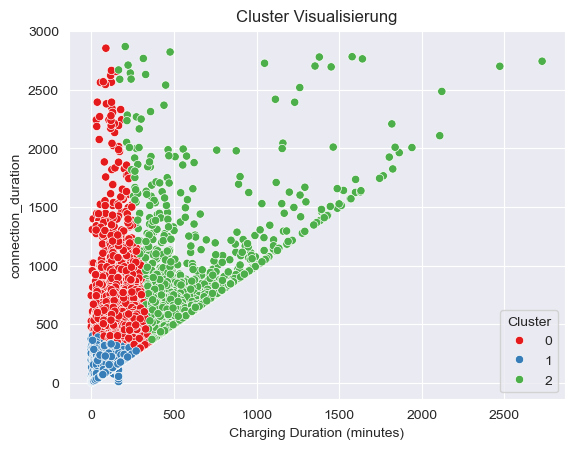

In [28]:
# K-Means clustering with the optimum number of clusters (3 or 4)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_cleaned['Cluster'] = kmeans.fit_predict(data_scaled)

# Analyze average values per cluster and print
cluster_summary = df_cleaned.groupby('Cluster')[['charging_duration', 'connection_duration']].mean()
print(cluster_summary)

# Visualization of the clusters
sns.scatterplot(
    x='charging_duration',
    y='connection_duration',
    hue='Cluster',
    data=df_cleaned,
    palette='Set1'
)
plt.xlabel('Charging Duration (minutes)')
plt.ylabel('connection_duration')
plt.title('Cluster Visualisierung')
plt.show()


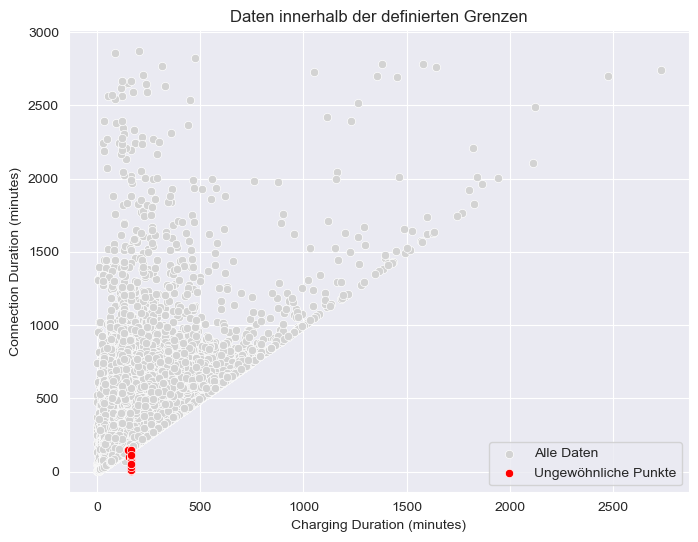

Ungewöhnliche Daten (innerhalb der Grenzen):
       counter                        id            connectionTime  \
227        227  5e2a48e8f9af8b75aed8e970 2020-01-07 16:09:01-08:00   
952        952  5e3e0f6ef9af8b0d07eefaac 2020-01-22 16:43:36-08:00   
1625      1625  5e4f32d5f9af8b6104b556fe 2020-02-04 11:41:31-08:00   
2847      2847  5e701ab2f9af8b4841ae7e02 2020-02-28 07:55:57-08:00   
3763      3763  5ea6278df9af8b4a2e7bd22a 2020-04-10 06:17:59-07:00   
...        ...                       ...                       ...   
56242     4655  5c367179f9af8b4639a8f2e7 2018-12-21 14:16:11-08:00   
58435     2073  5c7eed22f9af8b1308c33e9c 2019-02-16 16:39:16-08:00   
60411     4049  5cb3d2a8f9af8b4551261e75 2019-03-29 17:32:10-07:00   
61103     4741  5cca3a54f9af8b49aaa4cbac 2019-04-15 06:00:59-07:00   
61117     4755  5cca3a54f9af8b49aaa4cbba 2019-04-15 06:52:45-07:00   

                 disconnectTime          doneChargingTime  kWhDelivered  \
227   2020-01-07 18:38:46-08:00 2020-01

In [30]:
# Bedingung für ungewöhnliche Datenpunkte (innerhalb der definierten Grenzen)
unusual_data = df_cleaned[
    (df_cleaned['charging_duration'] >= 150) & (df_cleaned['charging_duration'] <= 500) &  # Charging Duration innerhalb [150, 500]
    (df_cleaned['connection_duration'] >= 0) & (df_cleaned['connection_duration'] <= 150)  # Connection Duration innerhalb [0, 160]
]

# unusual_data = df_cleaned[
#     (df_cleaned['charging_duration'] == 165.55)
# ]

# Visualisierung der ungewöhnlichen Datenpunkte im Kontext des gesamten Datensatzes
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='charging_duration',
    y='connection_duration',
    data=df_cleaned,
    color='lightgrey',  # Hintergrunddaten in Grau
    label='Alle Daten'
)
sns.scatterplot(
    x='charging_duration',
    y='connection_duration',
    data=unusual_data,
    color='red',  # Ungewöhnliche Daten (innerhalb der Grenzen) in Rot
    label='Ungewöhnliche Punkte'
)
plt.xlabel('Charging Duration (minutes)')
plt.ylabel('Connection Duration (minutes)')
plt.title('Daten innerhalb der definierten Grenzen')
plt.legend()
plt.show()

# Ausgabe der ungewöhnlichen Daten
print("Ungewöhnliche Daten (innerhalb der Grenzen):")
print(unusual_data)

Hier ist wieder zu sehen, dass es die Daten sind, wo die disconecction time gefehlt hat

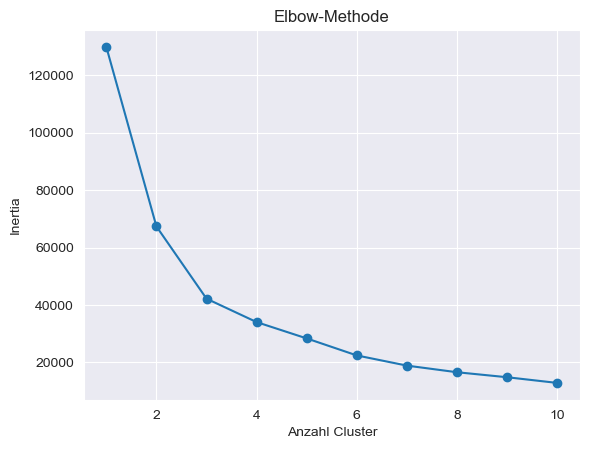

In [31]:
# Relevante Spalten auswählen
features = df_cleaned[['charging_duration', 'connection_duration']]

# Skalieren der Daten
scaler = StandardScaler()
data_scaled = scaler.fit_transform(features)

# Elbow-Methode zur Bestimmung der optimalen Cluster-Anzahl
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Plot der Elbow-Methode
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Anzahl Cluster')
plt.ylabel('Inertia')
plt.title('Elbow-Methode')
plt.show()

         charging_duration  connection_duration
Cluster                                        
0               300.941980           435.336214
1               110.947354           153.802175
2               529.642340           619.729940
3               147.008080           568.623257


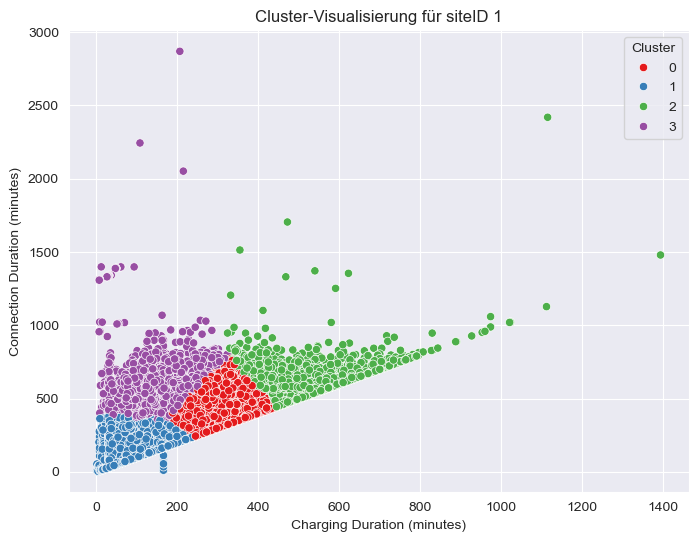

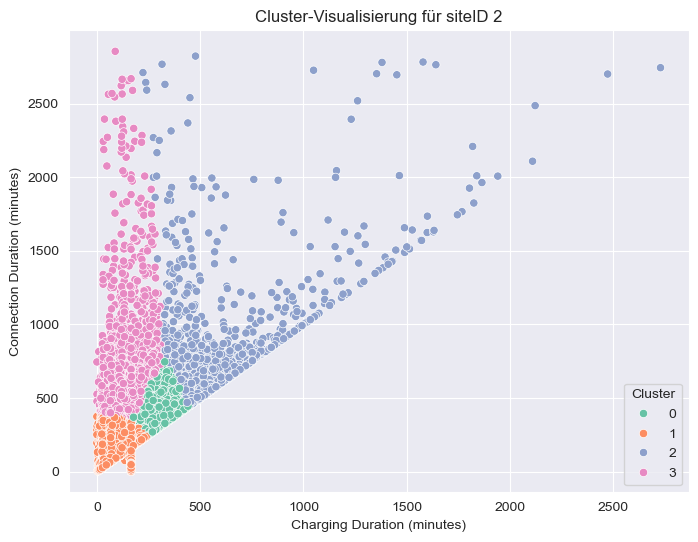

In [32]:
# K-Means-Clustering mit der optimalen Anzahl von Clustern (z. B. 3)
optimal_k = 4 #Ich finde hier machen vielleicht sogar 4 Sinn, aber die Elbow Methode sagt was anderes :sadface
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_cleaned['Cluster'] = kmeans.fit_predict(data_scaled)

# Durchschnittswerte pro Cluster analysieren
cluster_summary = df_cleaned.groupby('Cluster')[['charging_duration', 'connection_duration']].mean()
print(cluster_summary)

# Filter für siteID 1 und 2 und sicherstellen, dass die Cluster-Spalte noch vorhanden ist
df_site1 = df_cleaned[df_cleaned['siteID'] == '1']
df_site2 = df_cleaned[df_cleaned['siteID'] == '2']

# Visualisierung für siteID 1
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='charging_duration',
    y='connection_duration',
    hue='Cluster',  # Cluster als hue setzen
    data=df_site1,
    palette='Set1'
)
plt.xlabel('Charging Duration (minutes)')
plt.ylabel('Connection Duration (minutes)')
plt.title('Cluster-Visualisierung für siteID 1')
plt.legend(title='Cluster', loc='best')  # Legende hinzufügen
plt.show()

# Visualisierung für siteID 2
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='charging_duration',
    y='connection_duration',
    hue='Cluster',  # Cluster als hue setzen
    data=df_site2,
    palette='Set2'
)
plt.xlabel('Charging Duration (minutes)')
plt.ylabel('Connection Duration (minutes)')
plt.title('Cluster-Visualisierung für siteID 2')
plt.legend(title='Cluster', loc='best')  # Legende hinzufügen
plt.show()

Bei der Linie nach oben haben wir keine Idle Time sondern eine gleich lange Connction time wie Charging duration

Zu sehen ist, dass bei der Site 2 im Cluster 2 sehr hohe idle times sind und auf der Site 1 eher geringere Idle times sind und die Autos, nachdem das laden fertig ist den Platz auch wieder verlassen

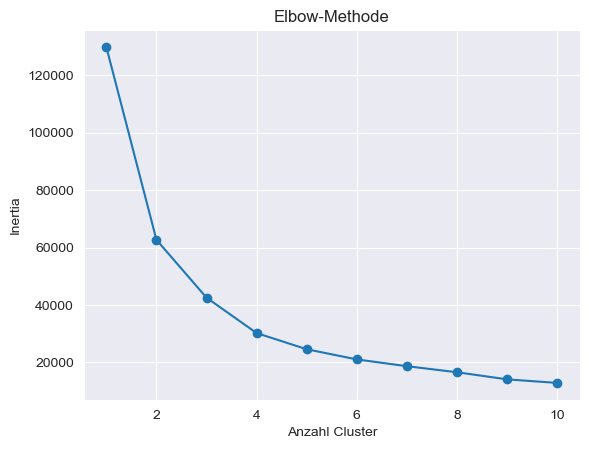

In [33]:
# Relevante Spalten auswählen
features = df_cleaned[['kWhDelivered', 'charging_duration']]

# Skalieren der Daten
scaler = StandardScaler()
data_scaled = scaler.fit_transform(features)

# Elbow-Methode zur Bestimmung der optimalen Cluster-Anzahl
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Plot der Elbow-Methode
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Anzahl Cluster')
plt.ylabel('Inertia')
plt.title('Elbow-Methode')
plt.show()

         kWhDelivered  charging_duration
Cluster                                 
0           14.550381         316.319878
1            6.455230         114.565503
2           36.815870         447.531882


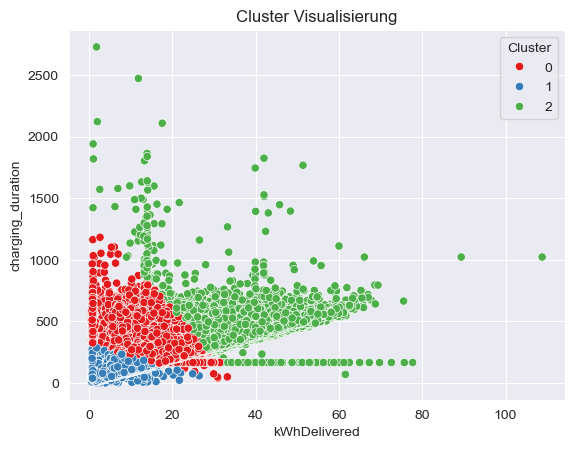

In [34]:
# K-Means-Clustering mit der optimalen Anzahl von Clustern (z. B. 3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_cleaned['Cluster'] = kmeans.fit_predict(data_scaled)

# Durchschnittswerte pro Cluster analysieren
cluster_summary = df_cleaned.groupby('Cluster')[['kWhDelivered', 'charging_duration']].mean()
print(cluster_summary)

# Visualisierung der Cluster
sns.scatterplot(
    x='kWhDelivered',
    y='charging_duration',
    hue='Cluster',
    data=df_cleaned,
    palette='Set1'
)
plt.xlabel('kWhDelivered')
plt.ylabel('charging_duration')
plt.title('Cluster Visualisierung')
plt.show()


Der Strich unten sind die Daten, die keine charging duration haben und wir diese mit dem Durchschnitt einfach genommen haben

In [35]:
# Check how many datapoints are out of normal because of missing Done Chargingtime
filtered_data = df_cleaned[
    (df_cleaned['charging_duration'] == 165.55) &
    (df_cleaned['kWhDelivered'] > 20)
]
# Anzahl der Ergebnisse
count = filtered_data.shape[0]
print(f"Anzahl der Ergebnisse: {count}")

# Ausgegebene Daten
print(filtered_data)


Anzahl der Ergebnisse: 909
       counter                        id            connectionTime  \
3756      3756  5ea3848df9af8b428bf97225 2020-04-08 09:36:53-07:00   
3768      3768  5ea7790bf9af8b4e1ade47c3 2020-04-11 13:00:31-07:00   
3770      3770  5eaa1c0df9af8b55cb21b43d 2020-04-13 06:24:18-07:00   
3773      3773  5eaa1c0df9af8b55cb21b440 2020-04-13 07:59:44-07:00   
3775      3775  5eaa1c0df9af8b55cb21b442 2020-04-13 09:20:33-07:00   
...        ...                       ...                       ...   
52836     1249  5c36631ef9af8b4639a8e599 2018-10-08 07:09:38-07:00   
52841     1254  5c36631ef9af8b4639a8e59e 2018-10-08 07:22:15-07:00   
52843     1256  5c36631ef9af8b4639a8e5a0 2018-10-08 07:27:15-07:00   
52855     1268  5c36631ef9af8b4639a8e5ac 2018-10-08 07:48:43-07:00   
56225     4638  5c367179f9af8b4639a8f2d6 2018-12-21 05:29:37-08:00   

                 disconnectTime          doneChargingTime  kWhDelivered  \
3756  2020-04-08 20:43:29-07:00 2020-04-08 12:22:26-07:00

In [36]:
# Check Outliners and if they are true
filtered_data = df_cleaned[
    (df_cleaned['charging_duration'] < 164.55) &
    (df_cleaned['kWhDelivered'] > 60)
]
# Anzahl der Ergebnisse
count = filtered_data.shape[0]
print(f"Anzahl der Ergebnisse: {count}")

# Ausgegebene Daten
print(filtered_data)

Anzahl der Ergebnisse: 1
       counter                        id            connectionTime  \
18648     4345  610c829df9af8b0580e98737 2021-07-20 15:20:06-07:00   

                 disconnectTime          doneChargingTime  kWhDelivered  \
18648 2021-07-21 08:18:06-07:00 2021-07-20 16:29:23-07:00     61.530327   

                                    sessionID siteID  spaceID    stationID  \
18648  1_1_179_791_2021-07-20 22:20:05.654930      1  AG-3F26  1-1-179-791   

                  timezone userID  \
18648  America/Los_Angeles    394   

                                              userInputs connection_date  \
18648  [{'WhPerMile': 283, 'kWhRequested': 28.3, 'mil...      2021-07-20   

       charging_duration  connection_duration  session_duration  Cluster  
18648          69.283333               1018.0            1018.0        2  


Ich finde, dass der Datenpunkt doch sehr komisch ist, in der Excel steht er aber auch so drin. Outlier oder was ist das?
User 394 hat insgesamt 23 charging sessions wovon aber keine auch nur ansatzweise die selbe Leistung erbracht. Auch nicht an der selben SpaceID und SpaceID
Feld Nummer 18650

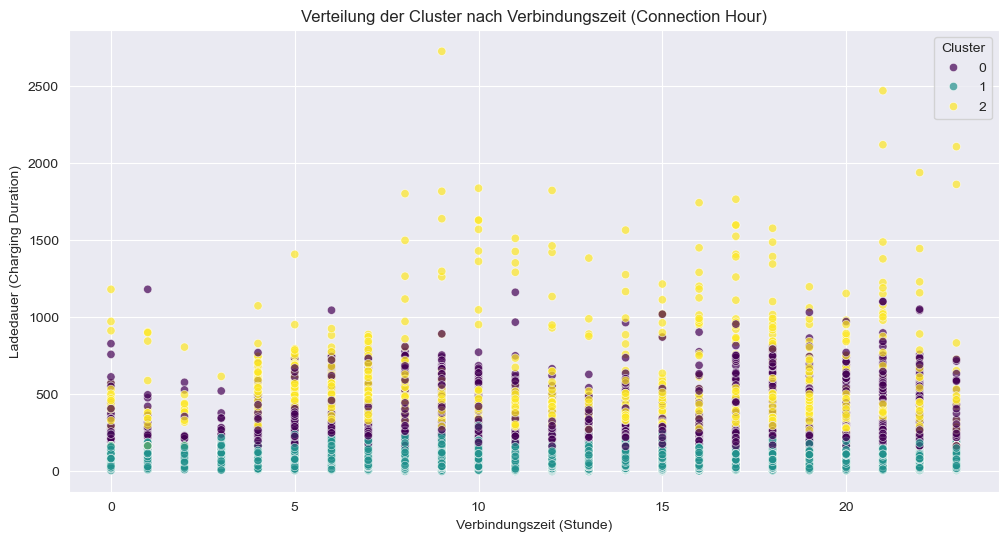

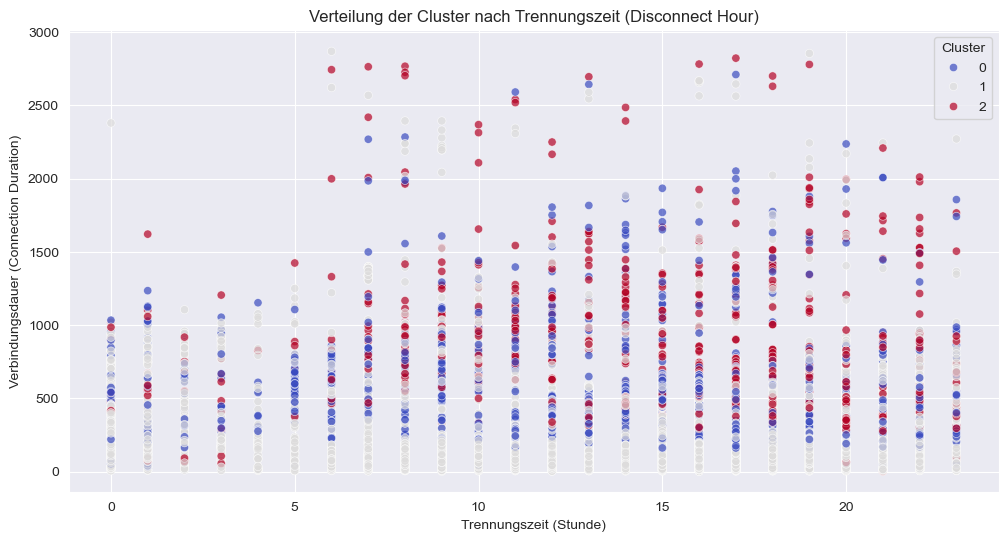

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Datumszeit in Stunden extrahieren
df_cleaned['connection_hour'] = pd.to_datetime(df_cleaned['connectionTime']).dt.hour
df_cleaned['disconnect_hour'] = pd.to_datetime(df_cleaned['disconnectTime']).dt.hour

# Scatterplot für die Verteilung der Cluster nach Verbindungszeit
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_cleaned,
    x='connection_hour',
    y='charging_duration',
    hue='Cluster',
    palette='viridis',
    alpha=0.7
)
plt.title('Verteilung der Cluster nach Verbindungszeit (Connection Hour)')
plt.xlabel('Verbindungszeit (Stunde)')
plt.ylabel('Ladedauer (Charging Duration)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Scatterplot für die Verteilung der Cluster nach Trennungszeit
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_cleaned,
    x='disconnect_hour',
    y='connection_duration',
    hue='Cluster',
    palette='coolwarm',
    alpha=0.7
)
plt.title('Verteilung der Cluster nach Trennungszeit (Disconnect Hour)')
plt.xlabel('Trennungszeit (Stunde)')
plt.ylabel('Verbindungsdauer (Connection Duration)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


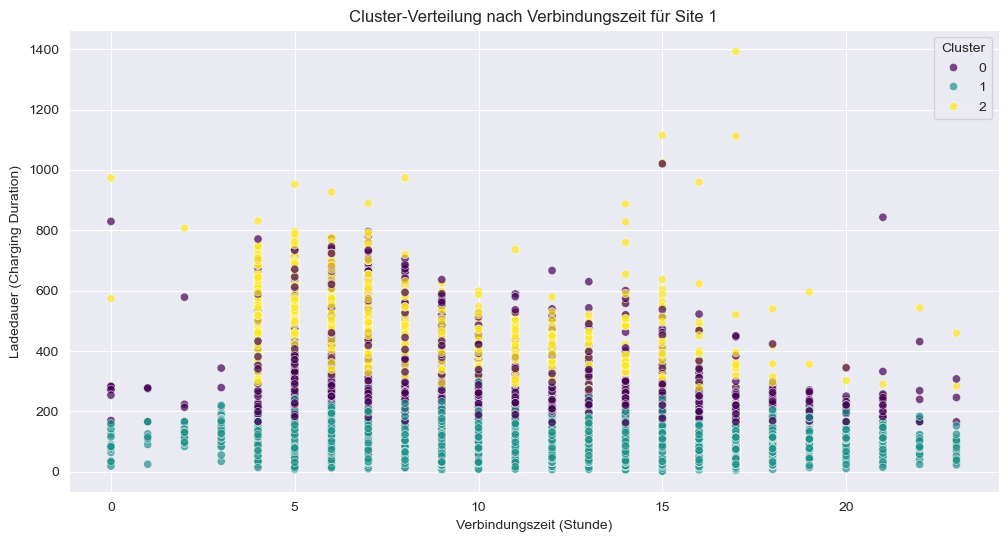

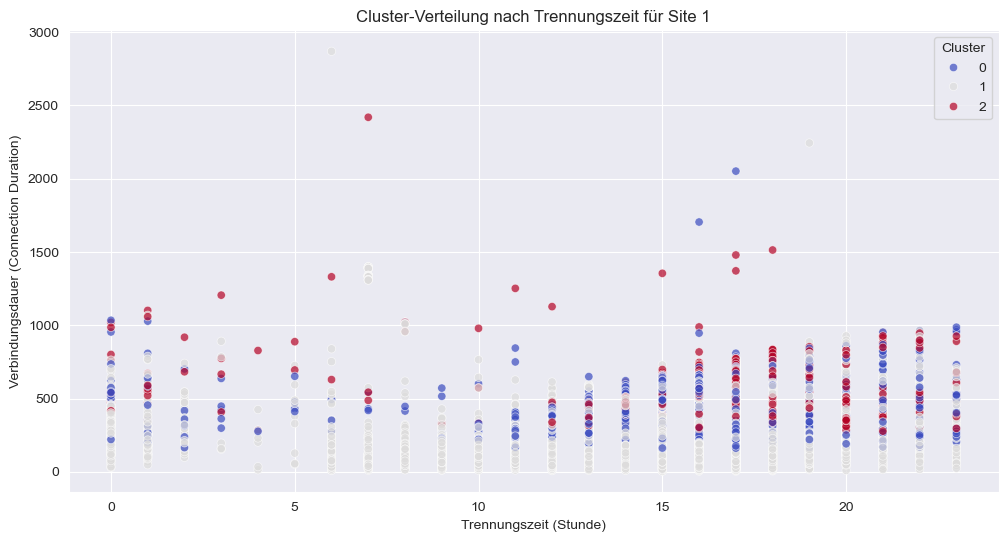

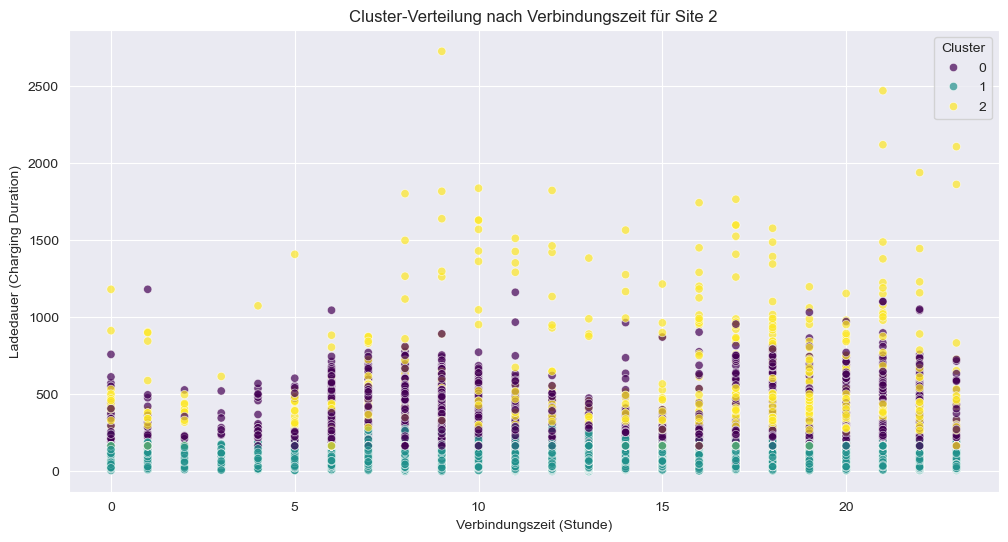

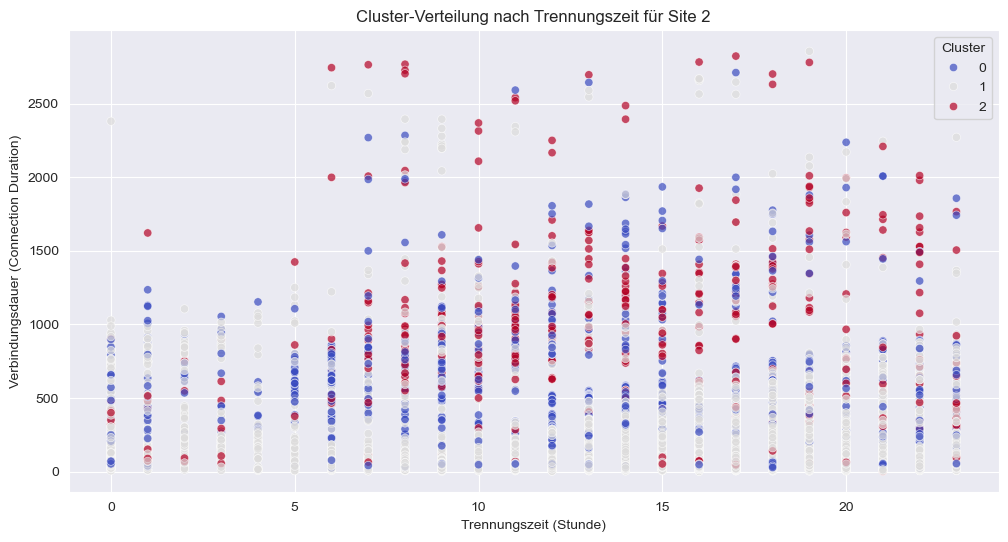

In [38]:
# Scatterplot für die Verteilung der Cluster nach Verbindungszeit, getrennt nach SiteID
site_ids = df_cleaned['siteID'].unique()

for site in site_ids:
    site_data = df_cleaned[df_cleaned['siteID'] == site]

    # Scatterplot: Verbindungszeit vs. Ladedauer
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=site_data,
        x='connection_hour',
        y='charging_duration',
        hue='Cluster',
        palette='viridis',
        alpha=0.7
    )
    plt.title(f'Cluster-Verteilung nach Verbindungszeit für Site {site}')
    plt.xlabel('Verbindungszeit (Stunde)')
    plt.ylabel('Ladedauer (Charging Duration)')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

    # Scatterplot: Trennungszeit vs. Verbindungsdauer
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=site_data,
        x='disconnect_hour',
        y='connection_duration',
        hue='Cluster',
        palette='coolwarm',
        alpha=0.7
    )
    plt.title(f'Cluster-Verteilung nach Trennungszeit für Site {site}')
    plt.xlabel('Trennungszeit (Stunde)')
    plt.ylabel('Verbindungsdauer (Connection Duration)')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()


War nur eine Idee, bringt aber eigentlich erstmal nicht so viel oder?